
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [6]:
%reset -f
import numpy as np

import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, vocs

evaluator = Evaluator(evaluate_TNK)

generator = MOBOGenerator(vocs, n_initial=10, proximal_lengthscales=[1.0,1.0])
xopt = XoptBase(generator, evaluator, vocs)
xopt.step()

In [7]:
for i in range(50):
    print(f'step {i}')
    xopt.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49


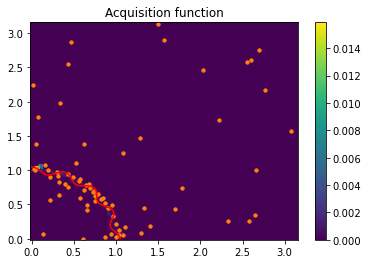

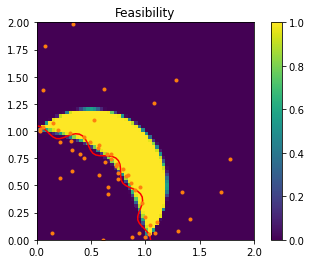

In [8]:
from xopt.generators.bayesian.utils import feasibility
from matplotlib import pyplot as plt# plot model predictions
bounds = vocs.bounds
history = xopt.history
model = generator.get_model(history)


n = 100
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = xopt.generator.get_acquisition(model)(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    ax.plot(*history[["x1","x2"]].to_numpy().T,'.C1')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        generator.options.acq.sampler,
        vocs
    ).flatten()

fig2, ax2 = plt.subplots()
c2 = ax2.pcolor(xx,yy,feas.reshape(n,n))
fig2.colorbar(c2)
ax2.set_title('Feasibility')

ax.plot(*history[["x1","x2"]].to_numpy().T,'.C1')


theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)
ax.plot(x_1, x_2_lower,'r')
ax2.plot(x_1, x_2_lower,'r')
ax2.plot(*history[["x1","x2"]].to_numpy().T,'.C1')
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 2)
ax2.set_aspect('equal')

          x1        x2               a        y1        y2         c1  \
0   2.223538  1.732199  dummy_constant  2.223538  1.732199   6.984168   
1   1.336272  0.442871  dummy_constant  1.336272  0.442871   0.942071   
2   0.752631  0.617307  dummy_constant  0.752631  0.617307  -0.052021   
3   0.617765  1.387992  dummy_constant  0.617765  1.387992   1.216720   
4   1.700715  0.436355  dummy_constant  1.700715  0.436355   2.146793   
..       ...       ...             ...       ...       ...        ...   
68  1.296409  0.077786  dummy_constant  1.296409  0.077786   0.629283   
69  2.557120  2.579616  dummy_constant  2.557120  2.579616  12.093524   
70  0.398751  0.792466  dummy_constant  0.398751  0.792466  -0.251477   
71  0.614872  0.001174  dummy_constant  0.614872  0.001174  -0.721884   
72  0.057455  1.377828  dummy_constant  0.057455  1.377828   0.823130   

          c2 some_array  done       c1_f      c2_f  feasibility  
0   4.488898  [1, 2, 3]  True  -6.984168  3.988898       

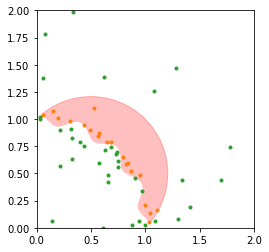

In [9]:
fig,ax = plt.subplots()

theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)

#ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc='white')
circle = plt.Circle((0.5, 0.5), 0.5**0.5,
                    color='r', alpha=0.25, zorder=0,
                    label='Valid Region')
ax.add_patch(circle)
history = vocs.append_constraints(history)
print(history)

ax.plot(*history[["x1","x2"]][history["feasibility"]].to_numpy().T,'.C1')
ax.plot(*history[["x1","x2"]][~history["feasibility"]].to_numpy().T,'.C2')

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')

In [10]:
history


,x1,x2,a,y1,y2,c1,c2,some_array,done,c1_f,c2_f,feasibility
0,2.223538,1.732199,dummy_constant,2.223538,1.732199,6.984168,4.488898,"[1, 2, 3]",True,-6.984168,3.988898,False
1,1.336272,0.442871,dummy_constant,1.336272,0.442871,0.942071,0.702614,"[1, 2, 3]",True,-0.942071,0.202614,False
2,0.752631,0.617307,dummy_constant,0.752631,0.617307,-0.052021,0.077583,"[1, 2, 3]",True,0.052021,-0.422417,False
3,0.617765,1.387992,dummy_constant,0.617765,1.387992,1.216720,0.802399,"[1, 2, 3]",True,-1.216720,0.302399,False
4,1.700715,0.436355,dummy_constant,1.700715,0.436355,2.146793,1.445767,"[1, 2, 3]",True,-2.146793,0.945767,False
...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.296409,0.077786,dummy_constant,1.296409,0.077786,0.629283,0.812532,"[1, 2, 3]",True,-0.629283,0.312532,False
69,2.557120,2.579616,dummy_constant,2.557120,2.579616,12.093524,8.556543,"[1, 2, 3]",True,-12.093524,8.056543,False
70,0.398751,0.792466,dummy_constant,0.398751,0.792466,-0.251477,0.095788,"[1, 2, 3]",True,0.251477,-0.404212,False
71,0.614872,0.001174,dummy_constant,0.614872,0.001174,-0.721884,0.262023,"[1, 2, 3]",True,0.721884,-0.237977,False
